Copyright 2019 Willian Fuks

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# PAPIS.IO 19

Welcome to suffering, pain and knowledge >:)

This notebook will guide us through the [workshop](https://papislatam2019.sched.com/event/OPVj/building-a-simple-recommender-system-from-scratch-training-workshop) to take place at PAPIS 19. The slides used for the presentation will cover just a simple brief explanation of concepts while this notebook is intended to be deeper and more resourceful.

Our main goal here is to develop a fully serverless recommender system that is ready to handle production traffic on top of Google Cloud Platform (GCP). We'll be working on the algorithm, on its architecture design, deployment and finally serving personalization to a frontend API.

With no further ado, let's start.

# The Challenge

Essentially, the challenge is to build a recommender system to interact with our customers reliably and ready to handle high traffic load.

At Dafiti, as an example, these are the recommendations operating in the "product" page:

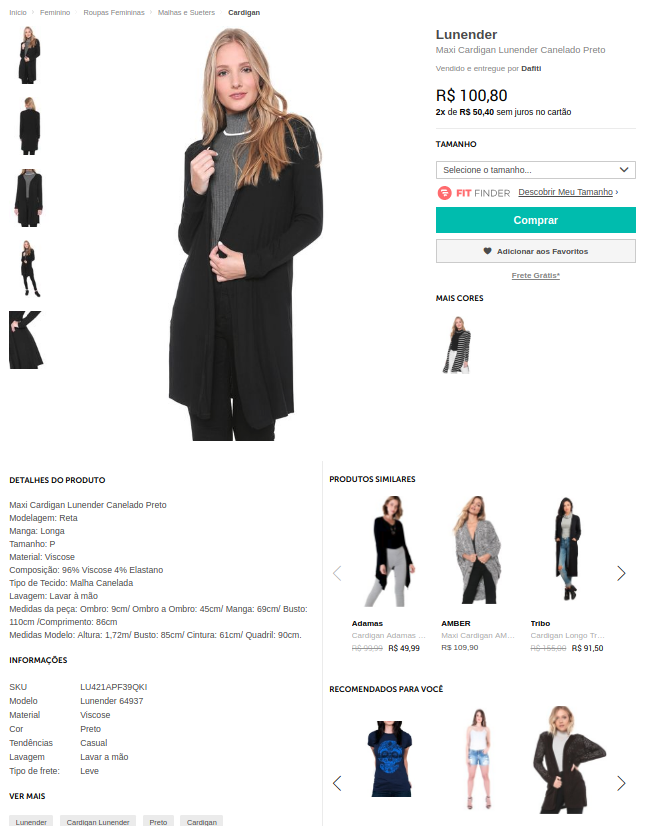

As we can see, we have two types of recommendations happening here: the first is what we call the "similar products" which means the system is supposed to bring back suggestions based on the main product of the page (the first strategy filters on the main's most specific category type).

The second slot is considered a less restricted scenario and the system is allowed to make any personalized suggestion to each customer (there's still filtering by the same gender as the main's).

We also use those in our email transactions. Here's an example (all in portuguese ;) ):

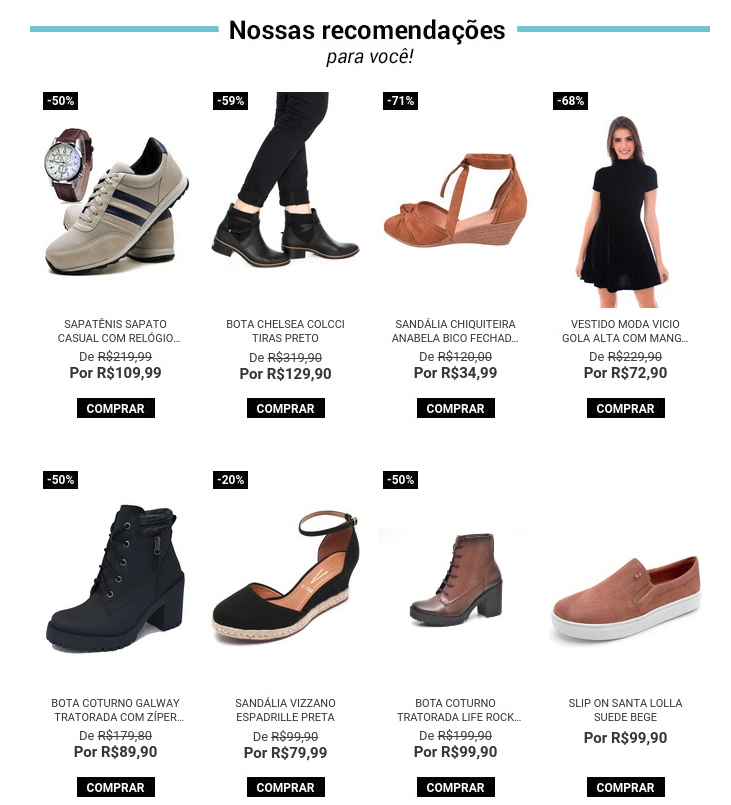

There are a plethora of different algorithms that can be implemented for tackling this challenge.

We'll start by learning one of the simplest ones and build the whole architecture using it. The idea is that once we understand how to implement a simple algorithm, going to the more complex stuff becomes considerably easier.

# 1 Collaborative Filtering

It's virtually impossible to talk about recommender systems without mentioning or using Collaborative Filtering.

As the name implies, the idea is to filter out products based on collaborative information from other customers that might have the same tastes as ours. The idea is to observe how customers are interacting with items and extract the concept of how similar either customers are among themselves or the other way around, how items are similar to each other.

If it's confusing, an image might help to visualize the idea:

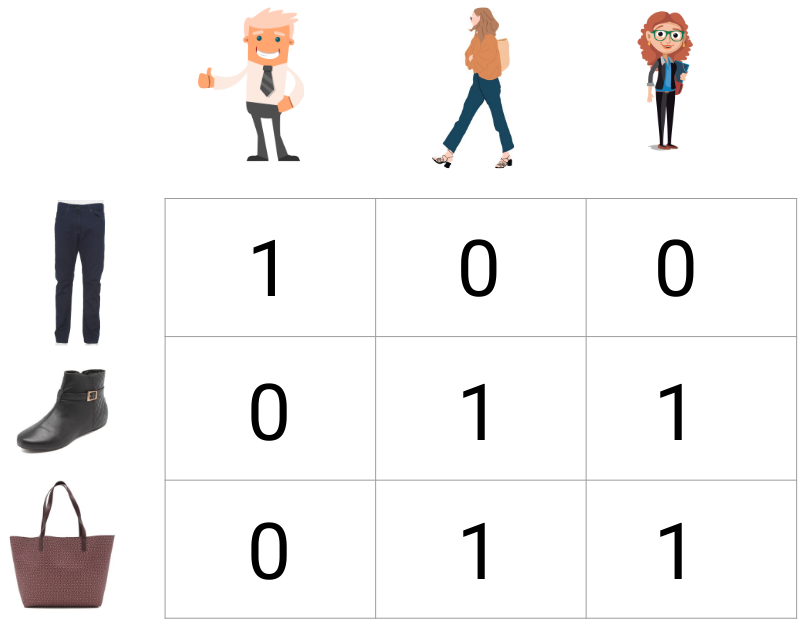

This is a matrix that represents the interactions of customers on a given eCommerce. The ones means the customer had some interaction with the product whereas zero means nothing has been observed.

Notice here that the signals we are observing have an implicit characteristic in the sense that we don't actually know if the customer really liked the product or maybe even if he or she bought it as a gift for somebody else. The best we can do is to map these behaviors with values that indicate a customer might have liked a given product.

These ideas were quite well developed [in the paper](http://yifanhu.net/PUB/cf.pdf) from Yehuda Koren which ended up influencing lots of new algorithms developed afterwards. In fact, we'll call these implicit feedbacks as $r_{ui}$ where "u" is an identification for the customer and "i" for product, as described in the literature.

Now, if we observe the matrix of interactions above, we observe some interesting dynamics: the male customer only interacted with the pants whereas the other two customers both interacted with the boot and the purse.

Notice here that their interactions are quite similar whereas not so for the first customer.

In collaborative filtering, we'll look for ways to express these similarities between customers or products and use those to find new items that could potentially be recommended.

And, in order to build this matrix, we need a way to map the implicit feedback into scores that reveal how much a customer might like a given product. This is so important for us that, in fact, it will be our first challenge >:)!

## 1.1 Implicit Feedback

So here's the deal: we need a strategy to score customers interactions with products; these scores are what we call "implicit feedback" as they give us some rough idea of how much a given customer enjoys a given item.

For now, we'll use the following rule:

If we observe that a customer browsed through an item, we'll add 0.5 points to the score between that customer and that product. If eventually we observe the customer added to basket the same product, then we'll add 2 points; 6 in case a purchase happens.

This all comes from the input data so with no further ado, let's see how our data is structed:

In [152]:
input_data = [
    {
        'customer0': [{'sku0': 'Browsed'}]
    },
    {
        'customer1': [
            {'sku1': 'Browsed'},
            {'sku1': 'AddedToCart'},
            {'sku1': 'Purchased', 'sku2': 'Browsed'}
        ]
    },
    {
        'customer2': [
            {'sku1': 'Browsed', 'sku2': 'Browsed'},
            {'sku1': 'AddedToCart'}
        ]
    },
    {
        'customer2': [
            {'sku2': 'AddedToCart'},
            {'sku2': 'Purchased'}
        ]
    }
]

Using the following rule:
- Item browsed: +0.5 points
- Added to cart: +2 points
- Purchased: +6 points

Our first challenge is to transform `input_data` to a matrix of interactions with appropriate implicit feedbacks. To do so, we need to map customer and items (from now on, "skus") to indices in the matrix. Regardless of what recommender system strategy you are developing, this step is basically default in any system setup.

This being said...let's do that!

In [144]:
def build_index_mapping(values):
    """
    Receives a list of values and returns a dictionairy where keys are the values and items are integer numbers.
    For example:
    
    >>> values = ['sku0', 'sku1']
    >>> mapping = build_index_mapping(values)
    >>> print(mapping)
    {'sku0': 0, 'sku1': 1}
    
    Args
    ----
      values: iterator object (list, tuple, set).
          List of values, such as customers identifications or skus for instace.
          
    Returns
    -------
      result: dict
          Mapping where key are the values and items are integer indeces. 
    """
    result = {}
    counter = 0
    # Iterate over values
    # Your code here
    return result

mock_values = ['sku0', 'sku1', 'sku2']
result = build_index_mapping(mock_values)
expected = {'sku0': 0, 'sku1': 1, 'sku2': 2}

assert result == expected

Let's build a mapping for our customers and skus:

In [145]:
customers_mapping = build_index_mapping(['customer0', 'customer1', 'customer2'])
assert customers_mapping == {'customer0': 0, 'customer1': 1, 'customer2': 2}

skus_mapping = build_index_mapping(['sku0', 'sku1', 'sku2'])
assert skus_mapping == {'sku0': 0, 'sku1': 1, 'sku2': 2}

Let's now take our input data and map it to our implicit feedback. To do so, we'll be using the previous mappings we obtained in the step before.

Let's do it:

In [146]:
BROWSE_SCORE = 0.5
CART_SCORE = 2.0
PURCHASE_SCORE = 6.0

In [153]:
from collections import defaultdict


def build_interactions_mapping(input_data, customers_mapping, skus_mapping):
    """
    `input_data` is a list of dictionaries where each key is the customer identification and the values
    is an array (list) of skus and the type of interaction.

    The output of this function has to be a new mapping, but this time already using the indices for
    customers and skus. Also, keep in mind our implicit feedback strategy where "browsed" adds +0.5 points
    and so on.

    Args
    ----
      input_data: list
          All customers interactions with the products of a given eCommerce.
      customers_mapping: dict
          Keys are customers and values are indeces.
      skus_mapping: dict
          Same as before.

    Returns
    -------
      result: dict
        Keys are the customers and values are all their implicit feedback interactions on products.
    """
    # We build `result` as a defaultdict so we can run operations like:
    # result[first_value][second_value] = float value
    result = defaultdict(lambda: defaultdict(float))
    
    # iterate over each dict in input_data
    # your code here
        
        # then iterate over each dict from previous step
        # more code here
    return result


interactions_mapping = build_interactions_mapping(input_data, customer_mapping, skus_mapping)
expected = {0: {0: 0.5}, 1: {1: 8.5, 2: 0.5}, 2: {1: 2.5, 2: 8.5}}
assert interactions_mapping == expected

In [154]:
print(dict(interactions_mapping))

{0: defaultdict(<class 'float'>, {0: 0.5}), 1: defaultdict(<class 'float'>, {1: 8.5, 2: 0.5}), 2: defaultdict(<class 'float'>, {1: 2.5, 2: 8.5})}


## 1.2 Numpy

So far so good!


Now, remember that our main goal in order to develop a recommender system is to extract similarities either between customers or skus by observing their interactions with items.

We'll be performing some mathematical operations upon this data; this being the case, it's time for us to start diving into numpy and scipy.

In [50]:
import numpy as np

In [47]:
print(dict(interactions_mapping))

{0: defaultdict(<class 'float'>, {2: 0.5}), 1: defaultdict(<class 'float'>, {1: 8.5, 2: 8.5}), 2: defaultdict(<class 'float'>, {1: 8.5, 2: 8.5})}


In [46]:
d

{0: defaultdict(float, {2: 0.5}),
 1: defaultdict(float, {1: 8.5, 2: 8.5}),
 2: defaultdict(float, {1: 8.5, 2: 8.5})}

In [36]:
row

{'customer0': [{'sku2': 'Browsed'}]}

Here's one tip for those learning python and stuff: if you want to see everything that is defined in the library, you can hit:

`np.` + TAB

This will open a list of possibilities for you.

Also, you can access methods and functions docstrings with the question mark symbol:

`np.reshape?` + ENTER

Here's a list of operations important for us to understand to implement a recommender system. This is important not only in Numpy but also this will be quite useful for Tensorflow later on.

In [52]:
a = np.array([1, 2, 3])
print(a)

[1 2 3]


In [54]:
a = np.array([[1, 2, 3], [2, 3, 4]])
print(a)

[[1 2 3]
 [2 3 4]]


In [56]:
a = np.random.rand(3, 2)
print(a)

[[0.04383127 0.22539029]
 [0.72683516 0.12878009]
 [0.71532049 0.71728136]]


In [58]:
a = np.array([1, 2, 3])
a.shape

(3,)

In [60]:
a = np.array([1, 2, 3])
a = np.reshape(a, [1, 3])
print(a)
print(a.shape)

[[1 2 3]]
(1, 3)


In [61]:
a = np.array([1, 2, 3])
a = np.reshape(a, [3, 1])
print(a)
print(a.shape)

[[1]
 [2]
 [3]]
(3, 1)


In [64]:
a = np.random.rand(3, 3)
print(a)
a = a[1, :]
print(a)
a = a[:-1]
print(a)

[[0.54833181 0.88542569 0.24063832]
 [0.02384303 0.60906252 0.15348633]
 [0.68311348 0.20410379 0.84001782]]
[0.02384303 0.60906252 0.15348633]
[0.02384303 0.60906252]


In [68]:
a = np.random.rand(2, 2)
print(a)
a[1, 1] = 5
print(a)

[[0.24156938 0.16691492]
 [0.12424169 0.42763359]]
[[0.24156938 0.16691492]
 [0.12424169 5.        ]]


This is the motivation for using numpy (or even tensorflow) for the mathematical operations:

In [73]:
# First let's multiply a python list by 5 to see how it goes:
py_a = [i for i in range(100000)]
%timeit [i * 5 for i in py_a]

8.34 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
py_a = np.array([i for i in range(100000)])
%timeit py_a * 5

100 µs ± 4.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Here's what we need to do now: the previous mapping of interactions we extract from our customers should become a numpy array. Remember that by doing so, it'll be much faster to implement and we'll be able to run several algebra linear methods from numpy and scipy.

As a side note, we'll be working later on with **similarities between products**. This means that the interactions matrix should contain customers in the rows and skus in the columns (reason for this will be clear later on. Briefly, it's just easier and faster).

This being said, let's do it >:)!

In [ ]:
def build_interactions_matrix(interactions_mapping, total_customers, total_skus):
    """
    From the customers and skus implicit feedback scores mapping, we'll build a numpy matrix that will
    help us on implementing our Recommender System. Remember, as we want to find similarities between
    skus (easier problem to solve and use in production), this matrix should contain customers in the rows
    and skus in the columns.
    
    Args
    ----
      interactions_mapping: dict
          This mapping has on the first key level the customer_id, then another mapping where key are
          skus and finally the values are the implicit feedback score observed from data, i.e, 
          {'customer 0': {'sku 0': 2.5, 'sku 1': 0.5}}
          
    Returns
    -------
      result: np.array
        This matrix carries the same information as `interactions_mapping` but it's a numpy array instead.
        Rows carries information about customers and columns, skus.
    """
    n_rows = total_customers
    n_cols = total_skus
    
    result = np.zeros((n_rows, n_cols))
    # iterate over the values of interactions_mapping and update result
    # your code here
    return result

interactions_matrix = build_interactions_matrix(interactions_mapping, len(customers_mapping), len(skus_mapping))
np.testing.assert_array_equal(interactions_matrix, np.array([[0.5, 0, 0], [0, 8.5, 0.5], [0, 2.5, 8.5]]))

Now that we have the interactions matrix, we can extract similarities scores between either skus or customers and use this information to build a recommender system.

In order to do so, we need first to understand the concept of "similarity".

# 1.3 Similarities

Now that we worked with interactions, it's time to extract value from those. We'll work on findig similarities between vectors.

As presented in the slides, here's the equation we'll be using to express the notion of "similar", which is also known as the "cosine" metric:

In [77]:
np.zeros((3, 3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

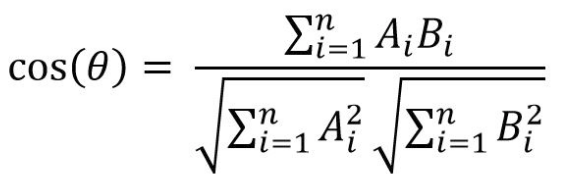

To make it easier to understand it, let's say we have two vectors, `a` and `b` defined as:

`a = np.array([1, 2, 3])`

and

`b = np.array([2, 3, 4])`

Then, the similarity between those vectors is, as defined by the cosine equation:

$$ sim(a, b) = \frac{1 * 2 + 2 * 3 + 3 * 4}{\sqrt{1^2 + 2^2 + 3^2}*\sqrt{2^2 + 3^2 + 4^2}} = 0.99258 $$

Let's first build a function that, given as input 2 arrays, returns the cosine similarity between them. Later on, we'll use this same code to find similarities between products from the `interactions_matrix`.

In [158]:
def compute_similarity(array1, array2):
    """
    Given two array inputs, returns the cosine similarity between both. A result of 0 (zero) means that
    the two vectors are not similar in any regards whereas a 1 (one) means equal.
    
    Args
    ----
      array: np.array
    
    Returns
    -------
      result: cosine similarity metric for input arrays
    """
    result = 0.0
    # result = your code here
    return result


assert compute_similarity(np.array([1, 0, 1]), np.array([0, 1, 0])) == 0.0
assert compute_similarity(np.array([1, 2, 3]), np.array([1, 2, 3])) == 1.0
np.testing.assert_almost_equal(compute_similarity(np.array([1, 2, 3]), np.array([2, 3, 4])),
                               20 / (np.sqrt(14) * np.sqrt(29)))

Now that we can compute similarities between vectors, we could also compute the similarities between products given customers interactions and use this information later on to make recommendations (more on this later on).

What we need to do now is to use as input the interactions matrix to come up with the similarities.

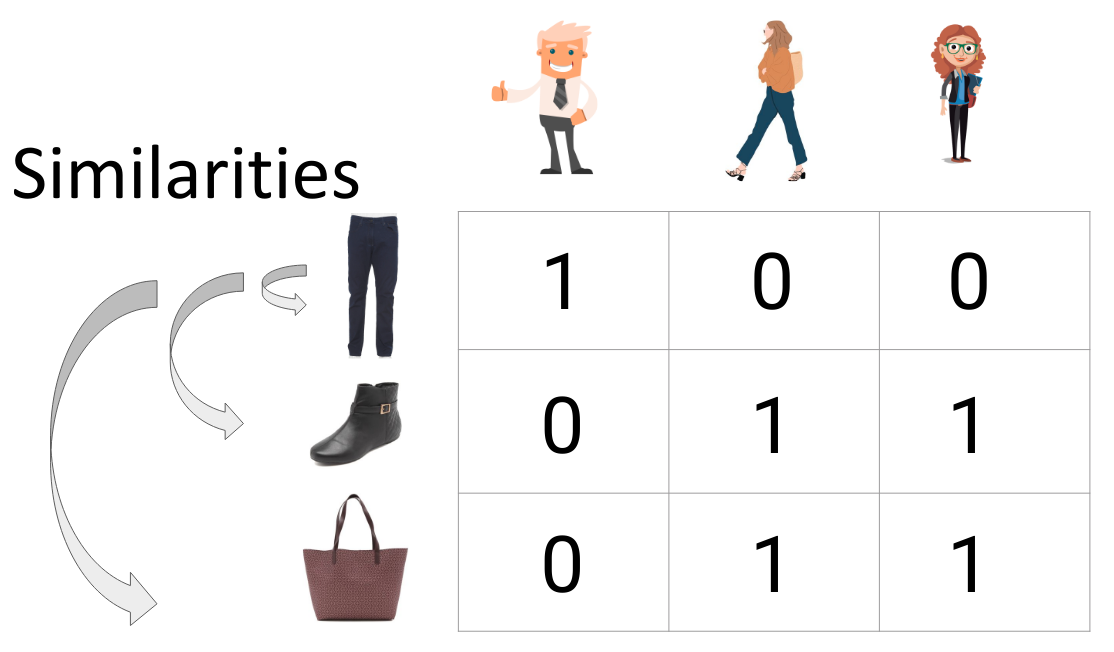

Using `interactions_matrix` as an example, build a function now that finds all similarities between all products. Remember, end-result should be a squared matrix  with rows and columns equal to the number of products observed in the training data.

In [178]:
print(interactions_matrix)

[[0.5 0.  0. ]
 [0.  8.5 0.5]
 [0.  2.5 8.5]]


In [165]:
def build_similarity_matrix(interactions_matrix):
    """
    With data collected from customers in our web-site, we use their behavior to find how similar products
    are among themselves. By doing so we can later on use this information for making new recommendations
    to customers.
    
    Args
    ----
      interactions_matrix: np.array
        Matrix where rows represents customers and columns the products.
        
    Returns
    -------
      results: np.array
        Similarity squared symmetric matrix representing how similar products are among themselves.
    """
    n_skus = interactions_matrix.shape[1]
    results = np.zeros((n_skus, n_skus))
    # write code to build the similarity matrix
    # for each value ranging from n_skus...
    # your code here
    return results

result = build_similarity_matrix(interactions_matrix)
expected = np.array([[1, 0, 0], [0, 1, 0.33801529], [0, 0.33801529, 1]])
np.testing.assert_almost_equal(result, expected)

So far so good!

but...

There's a big problem here...

Let's see what happens now if we keep increasing the size of the `interactions_matrix`:

In [176]:
from time import time


for size in [10, 100, 1000]:
    test_interactions_matrix = np.random.rand(size, size)
    t0 = time()
    test_similarity_matrix = build_similarity_matrix(test_interactions_matrix)
    tf = time()
    print("For size %d it took %f seconds" %(size, (tf - t0)))

For size: 10 it took 0.003708 seconds
For size: 100 it took 0.074436 seconds
For size: 1000 it took 15.335115 seconds


At Dafiti, for instance, this matrix takes up to millions of rows and columns. This means that we need a better way of dealing with these matrices.

And as it turns out, there's a technique we can implement here to make things much better. Here's where it gets clear why we have been using algebric matrices all along.

Here's how we can compute the similarity matrix by using linear algebra:

$$sim = {D^{-1}}^TAA^TD^{-1}$$

Where:

$A$ is the matrix of skus and interactions.

$D$ is the square root of the diagonal matrix of $AA^T$

In numpy, to find the transpose of a matrix $A^T$, simply run the command $A.T$ and it'll already work.

In [169]:
a = np.random.rand(2, 2)
print(a)
print(a.T)

[[0.65281665 0.40390492]
 [0.89876808 0.99915894]]
[[0.65281665 0.89876808]
 [0.40390492 0.99915894]]


In [182]:
def build_algebric_similarity_matrix(A):
    """
    Args
    ----
      A: a numpy array with dimension nxm where for the most part, m >> n
      
    Returns
    -------
      A numpy array with nxn dimensions where each cell represents the similarity
      level between its correspondent row id and column id.
      
    Notes
    -----
      Your mission is to compute the similarity matrix given by the equation
      sim = D^{-1}AA^TD^{-1} where A is the matrix of skus in rows and customers in columns.
      Each cell is an implicit value expressing how the customer interacted with the
      respective product.
    """
    # First compute the matrix AA^T. Learn about the function `dot` from numpy.
    # ...your code here...
    
    # Then you'll need the matrix D. To do so, you'll have to first initialize a
    # matrix of zeros the same shape as AA^T and then use the diagonal from the previous
    # step. Remember about applying the square root.
    # ... your code here ...
    
    # As inverting a matrix is potentially expensive given its algorithmic complexity:
    # https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra
    # it's probably a good idea to first compute it and then finally use the value in
    # the final operation
    
    # ... your code here ...
    
    # Finally, compute the final equation D^-1AA.TD^-1. Notice you don't need to transpose
    # D as the result would be the same.
    
    # ... your code here ...
    
    # Now you can return the result
    return result


result = build_algebric_similarity_matrix(interactions_matrix)
expected = np.array([[1, 0, 0], [0, 1, 0.33801529], [0, 0.33801529, 1]])
np.testing.assert_almost_equal(result, expected)

In [183]:
for size in [10, 100, 1000]:
    test_interactions_matrix = np.random.rand(size, size)
    t0 = time()
    test_similarity_matrix = build_algebric_similarity_matrix(test_interactions_matrix)
    tf = time()
    print("For size %d it took %f seconds" %(size, (tf - t0)))

For size 10 it took 0.005004 seconds
For size 100 it took 0.050454 seconds
For size 1000 it took 0.273072 seconds


This is considerable faster :)!

BUT

We have yet another problem.

Most values inside the matrix `interactions_matrix` are zeros!

Again, taking Dafiti as an example, we receive more than one million customers visits everyday. This means our matrix has millions rows, millions columns and most of its values are just 0s (zeros)! End result is something like:

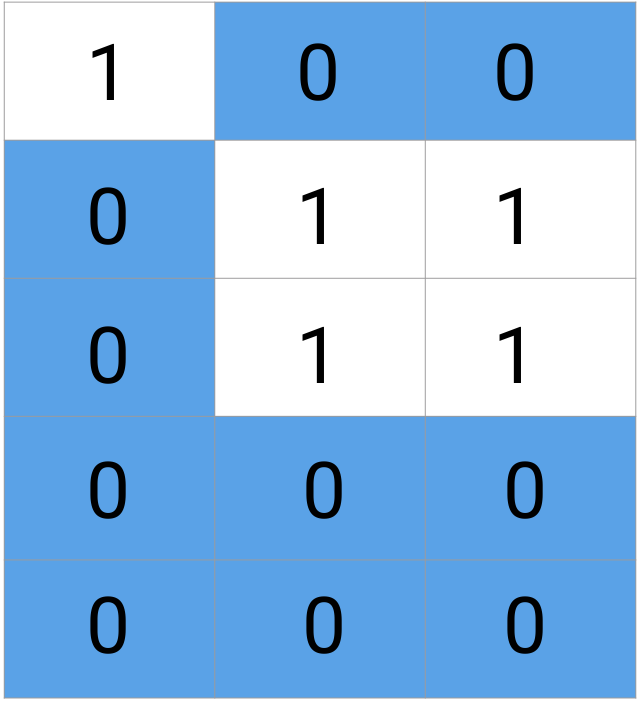

This means we need to use a massive amount of memory just to record a value that essentially is not required (any valid operation on zero either remains the same or is zero); if we could not store those zeros any longe in memory, that would cut down expenses considerably.

As it turns out, matrices where most values are zeros is a common thing when working in machine learning problems. In fact, a whole set of techniques and operations were created just to deal with those. That's what we shall learn now.

## 1.4 Sparse Similarity Matrix

Let's learn about sparse matrices. This concept is quite powerful and extensively used in machine learning so knowing its basics is important.

In order to use them, let's make use of the powerful library `scipy`:

In [184]:
from scipy import sparse

Scipy offers us 7 different possibilities for representing sparse matrices:

- bsr_matrix: Block Sparse Row matrix
- coo_matrix: COOrdinate format matrix
- csc_matrix: Compressed Sparse Column matrix
- csr_matrix: Compressed Sparse Row matrix
- dia_matrix: Sparse matrix with DIAgonal storage
- dok_matrix: Dictionary Of Keys based sparse matrix.
- lil_matrix: Row-based linked list sparse matrix

Each offers a specific advantage, for instance, `dok` or  `coo` are optimized for matrix construction whereas `csc` is optimized for algebric operations and slicing on column dimension, i.e., `a[:, 1]`.

For our recommender system, our strategy will be to first use `coo_matrix` and then convert it to `csc_matrix` so that we can use it later on in the recommendation phase.

Let's see how to build a `coo_matrix`. The idea is quite simple: we'll need 3 vectors: the indices, columns and  respective values.

Let's say, for instance, we want to build this matrix:

$$
M=
  \begin{bmatrix}
    0 & 0 & 1 \\
    1 & 0 & 0 \\
    0 & 1 & 0
  \end{bmatrix}
$$

In this case, the vectors would be:

`I = [0, 1, 2]`

`C = [2, 0, 1]`

`V = [1, 1, 1]`

Which means: on row number 0 (zero) and column number two (2) there's a value of "1"; on row 1 and column 0 another value of 1. Finally, on row 2 and column 1, the last 1.

To build the `coo_matrix`, we just run the following:

`A = sparse.coo_matrix((V, (I, C)), shape=(3, 3))`

And that's it. Matrix `A` is essentially the same thing as it would be had we created a regular numpy matrix. Only difference though is that, in the former, only values different from zero are represented which saves memory and speed up operations.

In [189]:
dense_A = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]])

In [190]:
print(dense_A)

[[0 0 1]
 [1 0 0]
 [0 1 0]]


In [187]:
I = [0, 1, 2]
C = [2, 0, 1]
V = [1, 1, 1]

A = sparse.coo_matrix((V, (I, C)), shape=(3, 3))

In [188]:
print(A)

  (0, 2)	1
  (1, 0)	1
  (2, 1)	1


In [191]:
A.shape

(3, 3)

In [193]:
print(A.dot(A))

  (0, 1)	1
  (1, 2)	1
  (2, 0)	1


In [195]:
print(A.T)

  (2, 0)	1
  (0, 1)	1
  (1, 2)	1


Remember: what we want to do here is to reduce storage consumption and improve performance of our recommender system. Not only our `interactions_matrix` but also our `similarity_matrix` contains too much zeros and we need to improve their representation.

What we need to do now, therefore, is to re-create the similarity matrix in sparse representation.

To do so, we first need to make the `interactions_matrix` sparse. Let's do exactly that now >:)!

In [203]:
def build_sparse_interactions_matrix(interactions_mapping, total_customers, total_skus):
    """
    This function, just as before, also builds a matrix of interactions between customers and their related
    products. This time though the result should be sparse of type "csc"
    
    Args
    ----
      interactions_mapping: dict
          This mapping has on the first key level the customer_id, then another mapping where key are
          skus and finally the values are the implicit feedback score observed from data, i.e, 
          {'customer 0': {'sku 0': 2.5, 'sku 1': 0.5}}
          
    Returns
    -------
      result: sparse.csc_matrix
        Rows represents customers and columns the skus. Same idea as before but this time the matrix
        will be sparse.
    """
    n_rows = total_customers
    n_cols = total_skus
    
    I, C, V = [], [], []
    
    # similar as before, let's iterate again over the interactions values
    # and build the matrix from there
    
    # ... your code here ...
    result = sparse.coo_matrix(...).tocsc()
    return result

interactions_matrix = build_sparse_interactions_matrix(interactions_mapping, len(customers_mapping), len(skus_mapping))
np.testing.assert_array_equal(interactions_matrix.todense(), np.array([[0.5, 0, 0], [0, 8.5, 0.5], [0, 2.5, 8.5]]))

In [204]:
print(interactions_matrix)

  (0, 0)	0.5
  (1, 1)	8.5
  (2, 1)	2.5
  (1, 2)	0.5
  (2, 2)	8.5


In [205]:
print(type(interactions_matrix))

<class 'scipy.sparse.csc.csc_matrix'>


In [212]:
def build_algebric_sparse_similarity_matrix(sparse_interactions_matrix):
    """
    Args
    ----
      sparse_interactions_matrix: sparse.csc_matrix
        Matrix of interactions of customers and skus in sparse representation.
        
        Important note: this matrix will be of type `sparse.csc_matrix`. There are lots of
        possibilities for sparse matrices. We'll be using one that optimizes column
        operations as this will make it possible for building the recommendations
        faster later on.
    
    Returns
    -------
      A sparse similarity matrix that does not contain any zero.
    """
    assert isinstance(sparse_interactions_matrix, sparse.csc_matrix)
    # First step is easy. Again, find A2 = AA^T
    # A2 = ...
    
    # ... your code here ...
    
    # The diagonal matrix is a bit different. Look within the `sparse` module for help here.
    # Remember: here you already can obtain the inverse of the squared root values of the diagonal of A2.
    # D = ...
    
    # ... your code here ...
    
    # Finally compute D^-1AA^TD^-1
    # Final result must be of type `csc_matrix`!
    # result = ...
    # return result
    # assert isinstance(result, sparse.csc_matrix)
    return result

sparse_similarity_matrix = build_algebric_sparse_similarity_matrix(interactions_matrix)
expected = np.array([[1, 0, 0], [0, 1, 0.33801529], [0, 0.33801529, 1]])
np.testing.assert_almost_equal(sparse_similarity_matrix.todense(), expected)

In [214]:
print(sparse_similarity_matrix)

  (0, 0)	1.0
  (2, 1)	0.33801529225650906
  (1, 1)	0.9999999999999998
  (2, 2)	0.9999999999999999
  (1, 2)	0.33801529225650906


Finally, we have our similarity matrix.

As a side note, all that is already implemented in sklearn already ;) You can import it as:

`from sklearn.metrics.pairwise import cosine_similarity`

We basically made you go through all this pain just to learn :)! That's what we call "tough love" >:)!!!

In [216]:
from sklearn.metrics.pairwise import cosine_similarity

In [222]:
cosine_similarity?

In [223]:
sim_matrix = cosine_similarity(interactions_matrix, dense_output=False)

In [225]:
print(sim_matrix)

  (0, 0)	1.0
  (1, 2)	0.33801529225650906
  (1, 1)	0.9999999999999998
  (2, 2)	1.0000000000000002
  (2, 1)	0.33801529225650906


Finally!

Finally!!

We are ready to make recommendations.

## 1.5 Making Recommendations

We already have the (by now) famous similarity matrix.

But the question now is: how to we make good use of it?!

Well, as it turns out, the answer is rather simple. All we have to do is to implement this equation:

$$
\hat{r}_{ui} = \frac{\sum_{j\in S^k(i;u)}s_{ij}r_{uj}}{\sum_{j\in S^k(i;u)}s_{ij}}
$$

In practice, as suggested by Koren's paper, we won't need to normalize (this simplifies a bit) so we'll use this equation:

$$
\hat{r}_{ui} = \sum_{j\in S^k(i;u)}s_{ij}r_{uj}
$$

Ok, it doesn't look that simple but it actually is quite simple ;). All it's saying is to get the skus a given customer interacted with and use their respective similarities to predict how much will be the implicit feedback on a new unknown sku.

Let's use images to make it more clear.

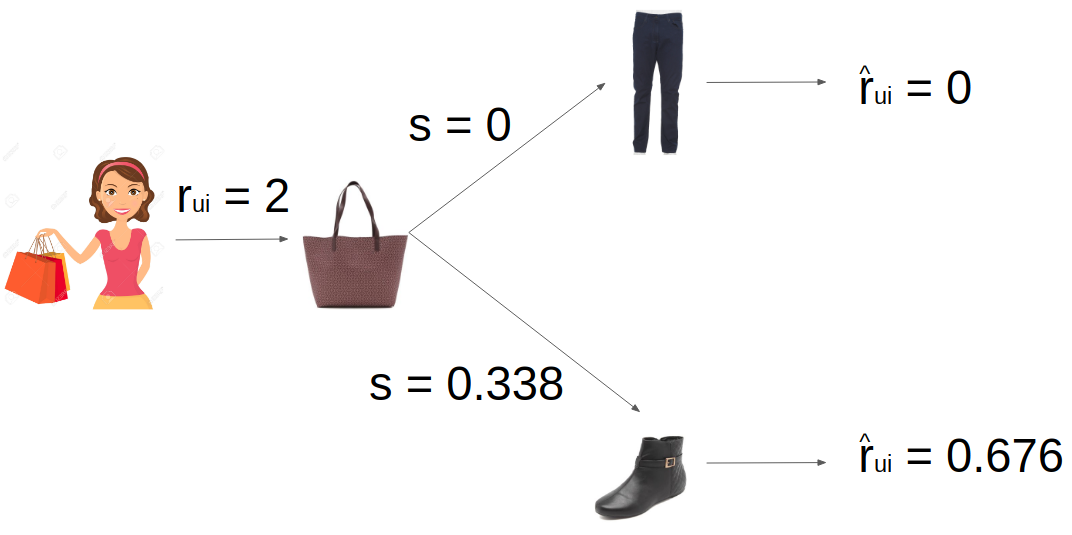

In the figure above, we observed a rating between the customer and the purse of 2 points. 

We also see that the similarity between the purse and the pants is 0 and 0.338 with the boots.

With this information, we can predict that the customer will enjoy the pants exactly 0 points (2 * 0) and will enjoy 0.676 the boots (2 * 0.338).

As we can see, we use the interactions of customers and the similarities between products to make an estimation of how much the customer would enjoy a given item. 

It's like the similarities creates a flow between customers preferences and how that will affect other skus perception.

Now all we do is, we extrapolate this idea to all items we have observed in our training database:

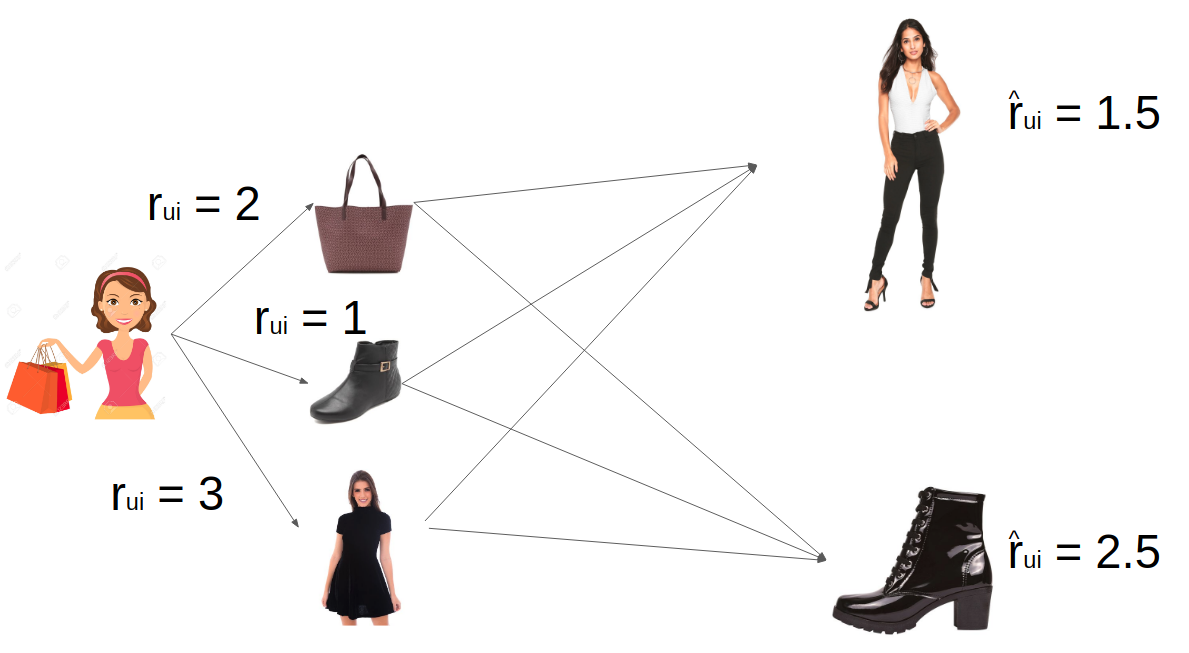

In the figure above, we are predicting how much the customer will enjoy the look and the boots. As we can see, by extrapolating the similarities, end result is that the look probably will receive `1.5` points and the boot `2.5`.

We therefore first would recommend the boots and then the look.

Its implementation is rather simple: we just take the dot product between the customer interactions and the similarity matrix. End result is the expected $\hat{r}_{ui}$ for each sku which then we'll need to sort in ascending order to bring best recommendations to customers:

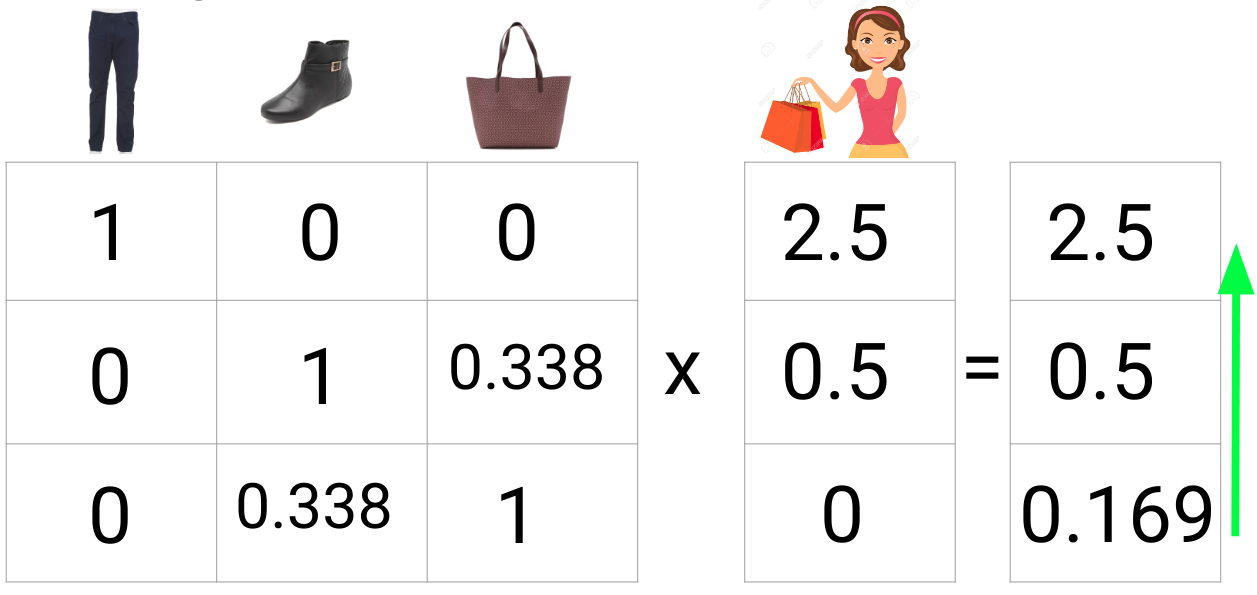

So, let's implement it!

First thing we need is to build the vector representing the interactions the customer had so far with the products. Remember from what we learned before, this vector must be sparse (potentially it could be dense but remember that if there are millions of skus, memory consumption can grow out of proportion.

What we'll do is to use the skus mapping build in the beginning of this workshop to build the vector.

In [226]:
skus_mapping

{'sku0': 0, 'sku1': 1, 'sku2': 2}

In [231]:
def build_customer_vector(customer_interactions, skus_mapping):
    """
    Builds a sparse vector from the interactions observed for the given customer. This vector will be
    used against the similarity matrix to build the final recommendations. If we receive as input
    a product that is not mapped in `skus_mapping` then we ignore it.
    
    Args
    ----
      customer_interactions: dict
        keys are the skus and values are the respective implicit feedback.
        
      skus_mapping: dict
        keys are skus and values the index associated to the similarity matrix.
        
    Returns
    -------
      interactions_matrix: sparse.csc_matrix
        Sparse vector with implicit feedback of the given customer.
        
    Raises
    ------
      ValueError: if no sku in input has a valid mapping.
    """
    I, C, V = [], [], []
    # iterate over the customer interactions
    # ... your code here ...
    result = sparse.coo_matrix(...)
    return result


customer_interactions = {'sku0': 0.5, 'sku1': 1}
customer_vector = build_customer_vector(customer_interactions, skus_mapping)
np.testing.assert_equal(customer_vector.todense(), np.array([[0.5], [1], [0]]))

Now that we have the customers interactions vector, all we are left with is multiplying it to the similarity matrix and obtaining the final vector with predictions for each sku.

We still have one problem though: we need to arrange this vector from best to worst!

As a final challenge before we have a recommender system, your mission will be to, given the input similarity matrix and the customer vector, find what should be the top n recommendations made to the customer.

Remember, we only need the top n recommendations: most places where we make recommendations to customers we only retrieve a certain specific amount of the suggestions (generally the top 10); this means we don't need to sort the entire vector: only the top best results.

In [234]:
def make_recos(similarity_matrix, customer_interactions, n):
    """
    Args
    ----
      similarity_matrix: sparse.csc_matrix
        A squared matrix with skus and their similarities among themselves.
      customer_interactions: sparse.csc_matrix
        Vector that represents what products a given customer interacted with and their
        respective scores.
      n: int, how many recommendations to retrieve.
    
    Returns
    -------
      results: list
        A list with top `n` best recommendations expressed in terms of indices of skus, i.e, 
        if the result is [4, 3, 2], then it means the best recommendation is the sku in index
        "4", then "3" and finally "2".
      
    Notes
    -----
      This is arguably the most challenging code of it all. In production, every millisecond
      we save here results in tremendous cuts in resources expenditure. Concepts such as
      "BigO" and algorithm complexity analysis comes in handy.
    """
    assert isinstance(similarity_matrix, sparse.csc_matrix)
    assert isinstance(customer_interactions, sparse.csc_matrix)
    assert n <= similarity_matrix.shape[0]
    # First we need to predict, given the input user array, how other items will be liked
    # respectively. This is the equation: \hat{r}_{ui} = \sum_{j\in S^k(i;u)}s_{ij}r_{uj}
    # That is, for each sku interacted, we get the correspondent similarity vector from
    # similarity matrix and multiply by the user interaction with that sku. We sum over
    # all skus to obtain the final scores we predict for each sku.
    # scores = ...
    
    # ... your code here ...
    
    # Now that you have the scores, we need to sort it to find which skus are the very best.
    # Precisely, we need to find the top `n` skus. To make things harder: the solution must
    # be O(m + nlog(n)) where `m` is the total amount of skus similarity matrix and `n` is
    # how many skus are desired in the final recommendation list. This will be challenging
    # so good luck ;)!
    # recos = ...
    
    # ... your code here ...
    return result

sim_matrix = sparse.csc_matrix([[1, 0.3, 0.2], [0.3, 1, 0.8], [0.2, 0.8, 1]])
user_matrix = sparse.csc_matrix([[1], [0], [2]])
n = 3
recos = make_recos(sim_matrix, user_matrix, n)
assert recos == [2, 1, 0]

Well, we have now the best indices of the skus in the similarity matrix! But this is not quite what we can send back to customers in production. Our system has to return the actual skus names.

This is accomplished by building an inverse mapping from our `skus_mapping` object.

If `skus_mapping` is given by `{'sku0': 0, 'sku1': 1, 'sku2': 2}`, then its inverse would be: `{0: 'sku0', 1: 'sku1', 2: 'sku2'}`.

Use the following function for finding the inverse mapping for skus:

In [238]:
def get_inverse_skus_map(skus_map):
    """
    Args
    ----
      skus_map: dict
        key is sku and value is its id
      
    Returns
    -------
      dict where key is the sku id and value is the sku itself.
      
    Notes
    -----
      This is our final exercise. It's quite simple actually. If we have
      as input {'sku0': 0, 'sku1': 1} then output should be the inverse,
      that is, {0: 'sku0', 1: 'sku1'}. By doing so, we can invert the
      recos list and see what skus they correspond to.
    """
    return {v: k for k, v in skus_map.items()}


inverse_skus_mapping = get_inverse_skus_map(skus_mapping)

In [237]:
print(inverse_skus_mapping)

{0: 'sku0', 1: 'sku1', 2: 'sku2'}


Finally, the system is ready. With this knowledge we can build recommender systems to go into production.